# Bioinformatic - Pipeline Comparison for BLG 604E

## OUTLINE

#### PART A) RESULTS FROM THE PIPELINES
1- Reading SNP vcf filenames generated as a result of the pipeline.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART B) RESULTS OF THE LL VALIDATED VCFS
1- Reading ll validated vcfs.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART C) SET OPERATIONS
1- Creating a set operations funtions. 
<br>2- Creating a intersection array from each sets. 
<br>3- Show Intersection Results in heatmap

#### PART D) COMPARISON WITH UNION VALIDATED VCF'S

## ABOUT DATA
50-51 : LL DATA
<br>44-45 : EA DATA
<br>79-80 : FD DATA
<br>74-83 : Il_1 DATA

## IMPORT SECTION

In [18]:
import os
import allel
import numpy as np # pip3 install matplotlib
import matplotlib.pyplot as plt # pip3 install matplotlib

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import math
import scipy.io as sio
from skimage import data, segmentation, color
from skimage.future import graph
from sklearn.preprocessing import MinMaxScaler

### Common Funtions

In [19]:
#Deleting indels from VCF
def remove_indels(t):
    t = t[t["REF"].apply(len) == 1 ]
    t = t[t["ALT_1"].apply(len) == 1]
    return t 

#Normalization
def normalization(df):
    return MinMaxScaler().fit_transform(np.array(df['Results']).reshape(-1,1))

#Apply Filter Pass if not somaticSniper
def filterPassControl(key,df):
    values = key.split('/')
    return df if values[len(values)-1] == 'somaticSniper' else df[df["FILTER_PASS"]]

## PART A) RESULTS FROM THE PIPELINES

### 1- Reading SNP vcf filenames generated as a result of the pipeline.

In [20]:
snp_filenames = {}
for root, directories, filenames in os.walk('vcf/snp'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            snp_filenames[root[8:]] = os.path.join(root,fn)

In [21]:
len(snp_filenames)

28

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [24]:
sets_dict = {}

filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(snp_filenames):
    
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(snp_filenames[key])
    #print(key)
    #display(temp.head())
    #Filtering - STARTS
    total_len = len(temp)
    temp = filterPassControl(key,temp) #FilterPass control for somaticSniper
    after_Filterpass_len = len(temp)
    temp = remove_indels(temp) 
    without_indels_len = len(temp)
    #temp = temp[temp["CHROM"].apply(lambda x: "_" in x)]
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    filtering_df.loc[len(filtering_df.index)] = [key , total_len, after_Filterpass_len,without_indels_len]
    
    #Creating a dictionary for each set
    if len(temp) != 0:
        sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 28/28 [00:17<00:00,  1.56it/s]


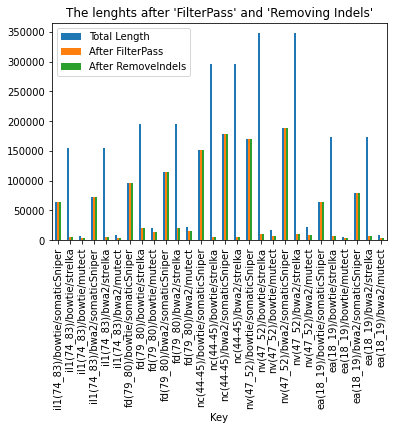

In [25]:
#Example
#len(sets_dict)
#len(sets_dict['50_51/bowtie/octopus'])
ax = filtering_df.plot('Key',kind='bar',title="The lenghts after 'FilterPass' and 'Removing Indels'")
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART B) RESULTS OF THE LL VALIDATED VCFS

### 1- Reading ll validated vcfs.

In [26]:
ll_filenames = {}
for root, directories, filenames in os.walk('vcf/validated_vcfs'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            ll_filenames[root[19:]] = os.path.join(root,fn)

In [34]:
len(ll_filenames)

72

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [28]:
ll_sets_dict = {}

ll_filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(ll_filenames):
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(ll_filenames[key])
    
    
    #Filtering - STARTS
    total_length = len(temp)
    temp = filterPassControl(key,temp) #FilterPass control for somaticSniper
    after_filterpass = len(temp)
    temp = remove_indels(temp)
    after_remove_indels = len(temp)
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    ll_filtering_df.loc[len(ll_filtering_df.index)] = [key , total_length, after_filterpass,after_remove_indels]

    #Creating a set for each dataframe
    if len(temp) != 0 :
        ll_sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 72/72 [00:08<00:00,  8.17it/s]


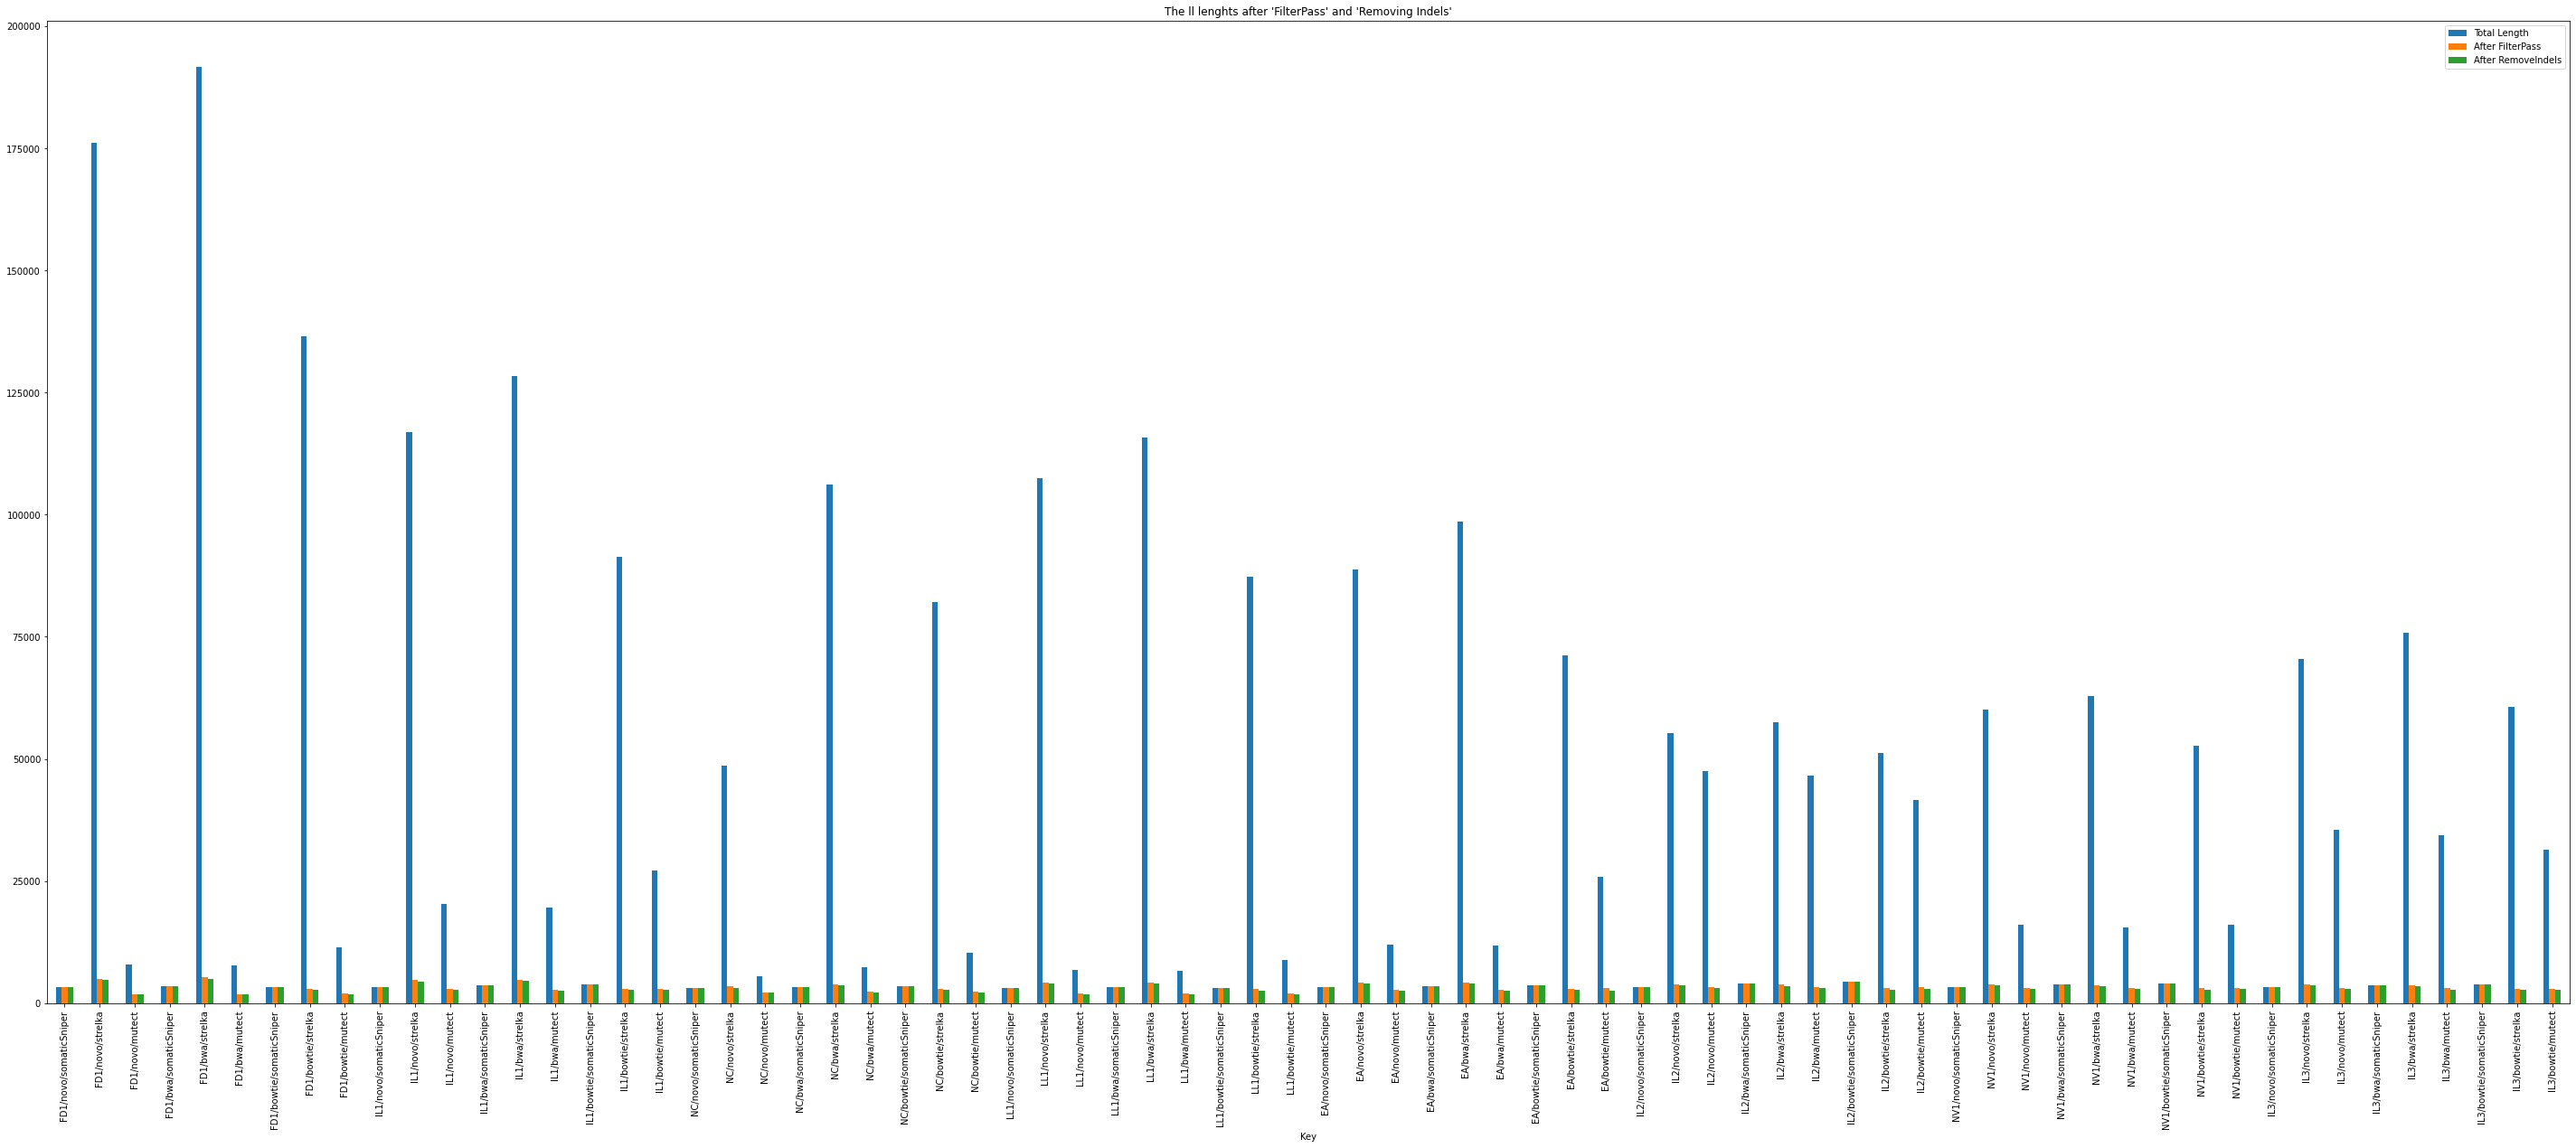

In [29]:
ax = ll_filtering_df.plot('Key',kind='bar',title="The ll lenghts after 'FilterPass' and 'Removing Indels'",figsize=(50,20))
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART C) SET OPERATIONS


### 1- Creating a set operations funtions.

In [30]:
#The intersection of two sets is the set of all the common elements of both the sets. 
def intersec(s1,s2):
    return len(s1.intersection(s2))

#The union of two sets is the set of all the elements of both the sets without duplicates.
def uni(s1,s2):
    return len(s1.union(s2))

#The difference between two sets is the set of all the elements in first set that are not present in the second set. 
def dif(s1,s2):
    return len(s1.difference(s2))

#Jaccard Similarity function for two sets
def js_set(s1, s2):
    intersection = len(list(set(s1).intersection(s2)))
    union = uni(s1,s2)
    return np.float64(round((float(intersection) / union) * 100) / 100);

### 2- Creating a intersection array from each sets. 

In [31]:
#Initializing a dataframe
df_js = pd.DataFrame(columns=["LL_VCF", "Result_VCF", "Results"])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in tqdm(ll_sets_dict): 
    for key2 in sets_dict:
        d_temp = pd.DataFrame([[key1, key2, js_set(ll_sets_dict[key1],sets_dict[key2])]],
                   columns=['LL_VCF', 'Result_VCF',"Results"])
        df_js = pd.concat((df_js,d_temp), ignore_index = True)
    
#Normalizing the results values with MinMaxScaler [0,1]
#df_t['Results'] = MinMaxScaler().fit_transform(np.array(df_t['Results']).reshape(-1,1))

#df_t
df_js

100%|███████████████████████████████████████████| 72/72 [00:10<00:00,  6.80it/s]


,LL_VCF,Result_VCF,Results
0,FD1/novo/somaticSniper,il1(74_83)/bowtie/somaticSniper,0.03
1,FD1/novo/somaticSniper,il1(74_83)/bowtie/strelka,0.30
2,FD1/novo/somaticSniper,il1(74_83)/bowtie/mutect,0.40
3,FD1/novo/somaticSniper,il1(74_83)/bwa2/somaticSniper,0.03
4,FD1/novo/somaticSniper,il1(74_83)/bwa2/strelka,0.30
...,...,...,...
2011,IL3/bowtie/mutect,ea(18_19)/bowtie/strelka,0.28
2012,IL3/bowtie/mutect,ea(18_19)/bowtie/mutect,0.46
2013,IL3/bowtie/mutect,ea(18_19)/bwa2/somaticSniper,0.02
2014,IL3/bowtie/mutect,ea(18_19)/bwa2/strelka,0.28


### 3- Show Intersection Results in heatmap

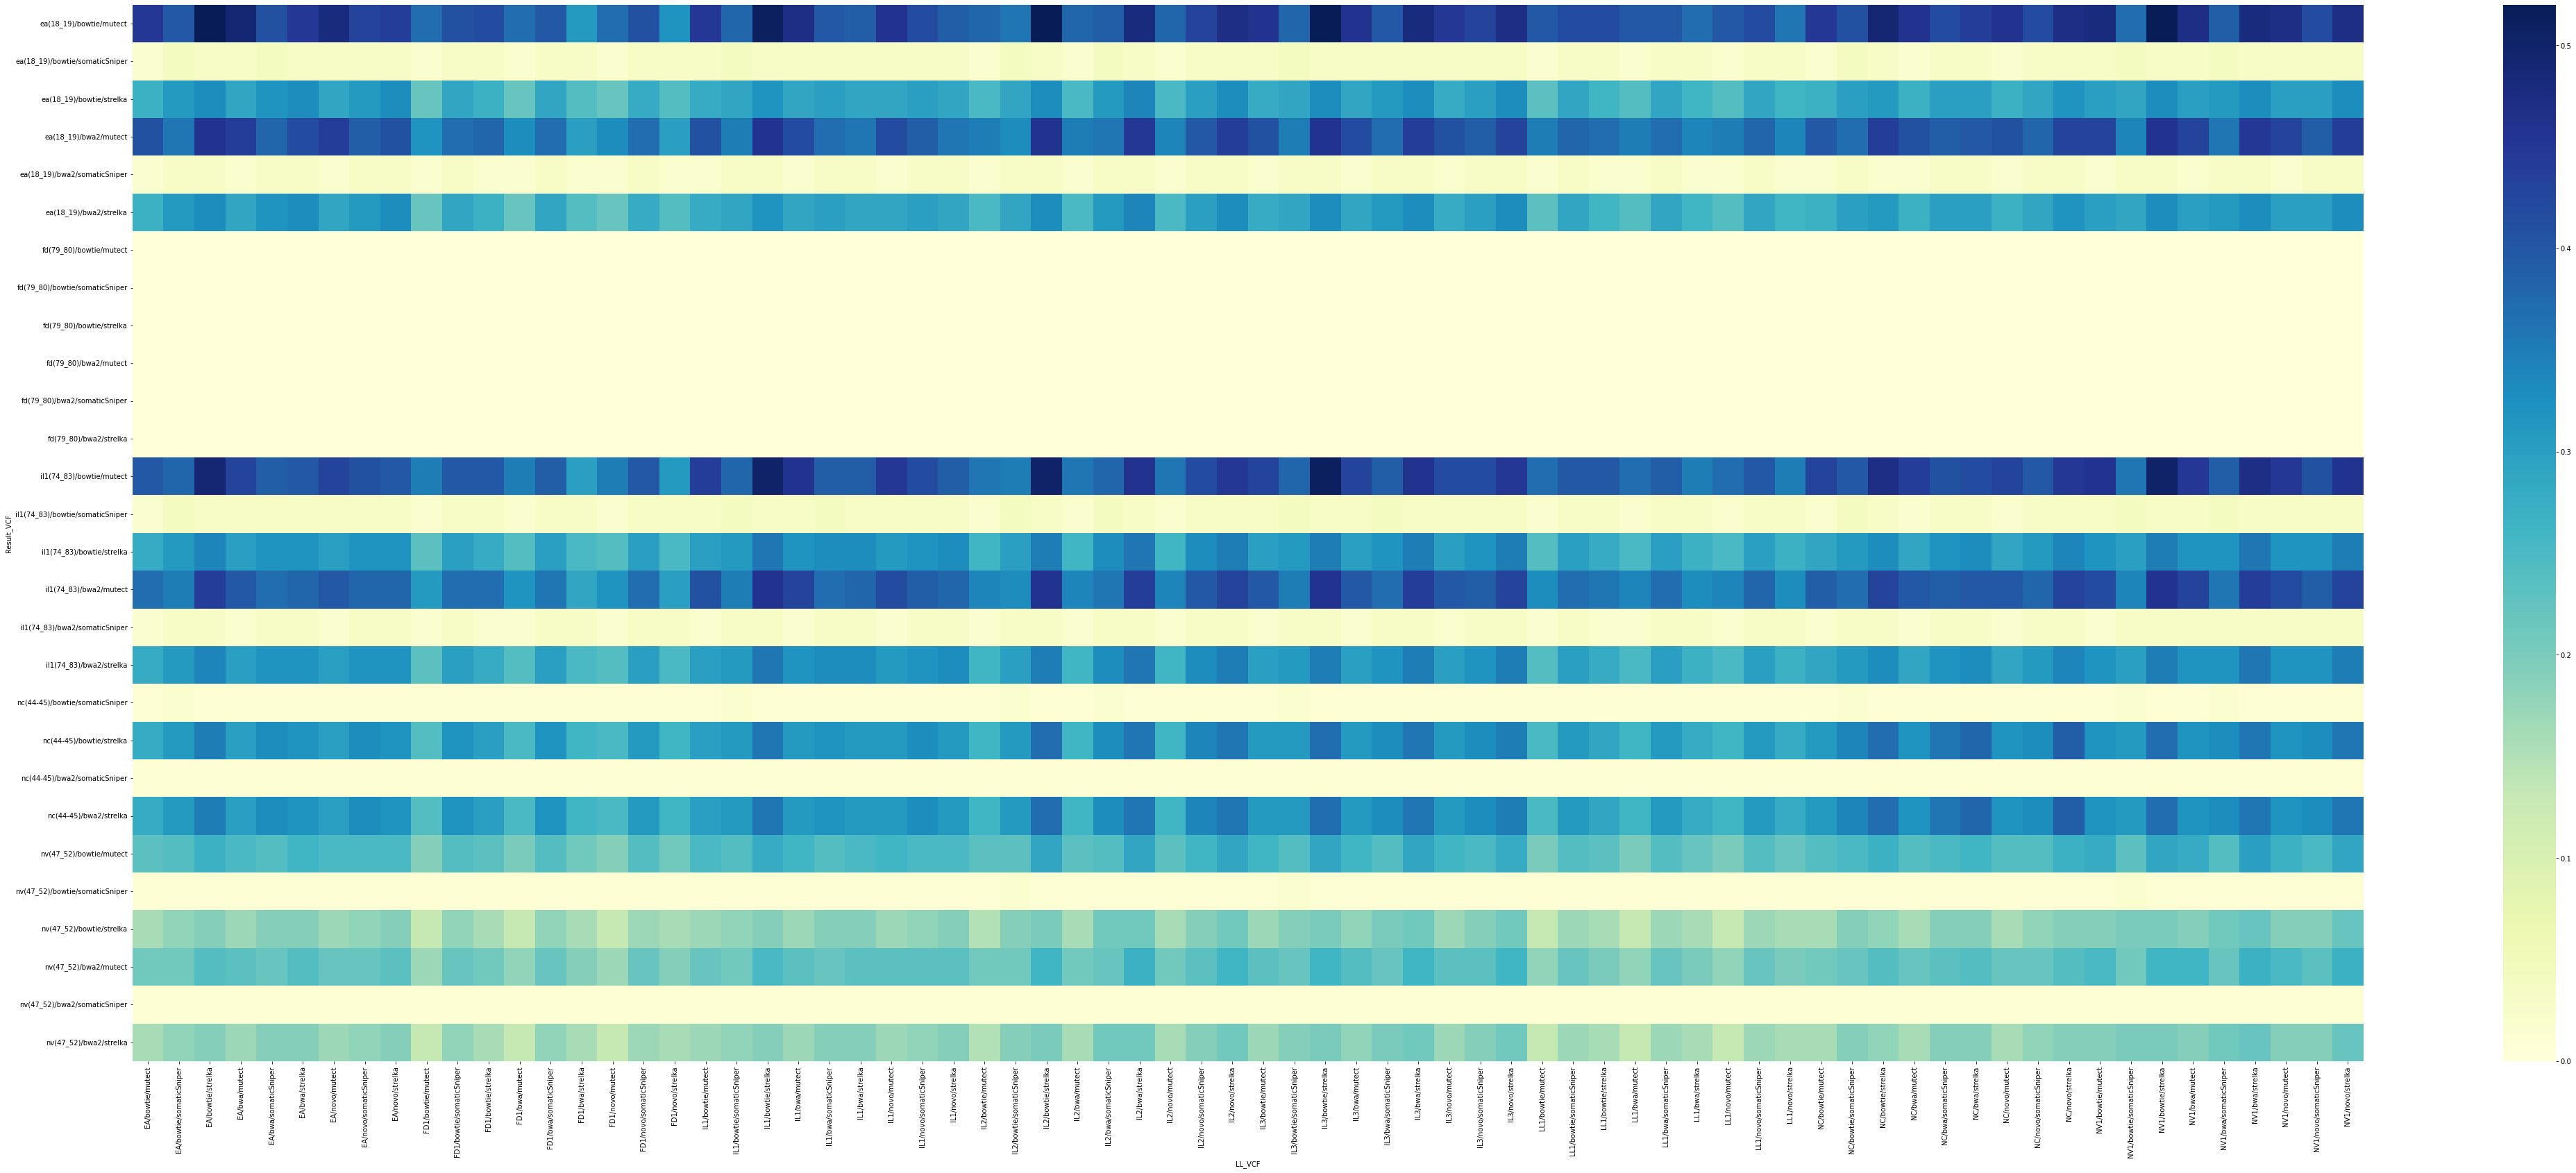

In [35]:
plt.figure(figsize = (72,28))
df_h = df_js.pivot("Result_VCF", "LL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_h, annot=False,cmap="YlGnBu")#, linewidths=.5)

### PART D) COMPARISON WITH UNION VALIDATED VCF'S

#### 1- Create a union of all ll validated vfc sets

In [33]:
#Creating union list from all ll validated vcf files
union_v_vcf = {}
for key in ll_sets_dict:
    union_v_vcf[key.split('/')[0]] = (set().union(*ll_sets_dict[].values()))

#len(union_v_vcf)
#union_ll_vcf
union_v_vcf

SyntaxError: invalid syntax (3516801434.py, line 4)

In [ ]:
#Initializing a dataframe
df_union = pd.DataFrame(columns=["V_VCF", "Result_VCF", "Results", 'length'])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in sets_dict:
    df_union[count] = ['Union', key1, js_set(union_ll_vcf,sets_dict[key1]),len(sets_dict[key1]) ]
    count += 1

#Taking transpose of the df and, getting rid of the first three rows then renaming axis again.
df_union_t = df_union.transpose().iloc[4: , :].set_axis(['V_VCF', 'Result_VCF', 'Results', 'length'], axis=1, inplace=False)

df_union_t

In [ ]:
df_union_h = df_union_t.pivot("Result_VCF", "V_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_union_h, annot=True,cmap="YlGnBu")

Gül Eda Aydemir